# DataTalks.Club MLOps Zoomcamp - Homework 1

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error

In [4]:
!pip install pyarrow

In [5]:
fpath = 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet'
df = pd.read_parquet(fpath)

In [6]:
len(df.columns)

19

## Q1
2023 Jan dataset has 19 columns

In [7]:
df.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
dtype: object

In [8]:
df['duration_td'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime

In [9]:
df['duration_td'].head()

0   0 days 00:08:26
1   0 days 00:06:19
2   0 days 00:12:45
3   0 days 00:09:37
4   0 days 00:10:50
Name: duration_td, dtype: timedelta64[us]

In [10]:
df.duration_td.std()

Timedelta('0 days 00:42:35.661074')

In [11]:
df['duration'] = df.duration_td.apply(lambda dtd: dtd.total_seconds()/60)

In [12]:
df.duration.head()

0     8.433333
1     6.316667
2    12.750000
3     9.616667
4    10.833333
Name: duration, dtype: float64

In [13]:
df.duration.std()

np.float64(42.59435124195458)

## Q2
In 2023 Jan, standard duration of trip duration was 42.59 minutes  

In [14]:
df.duration.isna().any()

np.False_

In [15]:
df_cl = df.loc[(df.duration >= 1) & (df.duration <= 60)].copy()

In [16]:
df_cl.shape[0]/df.shape[0]*100

98.1220282212598

## Q3
In Jan 2023 rides, 98.12% of the durations were between 1 and 60 minutes, inclusive.

In [17]:
categorical = ['PULocationID', 'DOLocationID']
numerical = [] #  ['trip_distance']

In [18]:
df_cl[categorical] = df_cl[categorical].astype(str)

In [19]:
df_cl[categorical].dtypes

PULocationID    object
DOLocationID    object
dtype: object

In [20]:
train_dicts = df_cl[categorical+numerical].to_dict(orient='records')

In [21]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [22]:
len(dv.feature_names_)

515

## Q4
one-hot encoding of the two categorical variables 'PULocationID', 'DOLocationID' yields 515 features

In [23]:
target = 'duration'
y_train = df_cl[target].values
y_train

array([ 8.43333333,  6.31666667, 12.75      , ..., 24.51666667,
       13.        , 14.4       ])

In [24]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [25]:
y_pred = lr.predict(X_train)

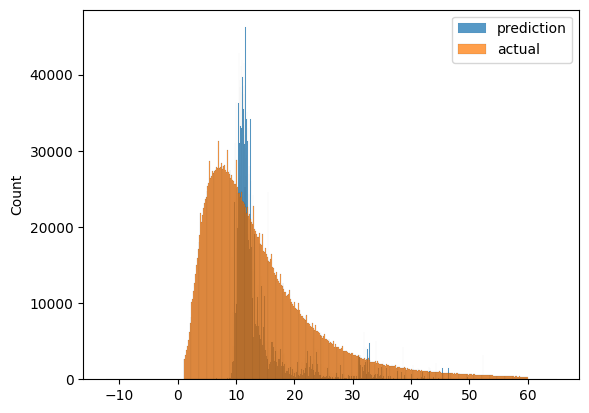

In [34]:
# sns.distplot(y_pred,label='prediction')
# sns.distplot(y_train, label='actual')
sns.histplot(y_pred,label='prediction')
sns.histplot(y_train, label='actual')
plt.legend()

In [30]:
# mean_squared_error(y_train, y_pred, squared=False)
root_mean_squared_error(y_train, y_pred)

7.649261929201487

## Q5
RMSE = 7.649 for training

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def get_ny_taxi_data(color, y, m):
    print(f'Fetching {color} taxi trip data for {y}-{m}')
    fpath = f'https://d37ci6vzurychx.cloudfront.net/trip-data/{color}_tripdata_{y}-{m}.parquet'
    df = pd.read_parquet(fpath)
    print(f'Dataset contains {df.shape[0]} records and {df.shape[1]} columns')
    return df

def calc_duration(df):
    df['duration_td'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df['duration'] = df.duration_td.apply(lambda dtd: dtd.total_seconds()/60)
    return df

def remove_outliers(df):
    df_cl = df.loc[(df.duration >= 1) & (df.duration <= 60)].copy()
    print(f'{df_cl.shape[0]/df.shape[0]*100}% of records are kept after outlier removal')
    return df_cl

def fit_transform_X(df, categorical, numerical, dv=None):
    df[categorical] = df[categorical].astype(str)
    dicts = df[categorical+numerical].to_dict(orient='records')
    if not dv:
        print(f'fit-transforming the features')
        dv = DictVectorizer()
        X = dv.fit_transform(dicts)
        print(f'{len(dv.feature_names_)} features will be used')
        return X, dv
    else:
        print(f'transforming the features')
        X = dv.transform(dicts)
        print(f'{len(dv.feature_names_)} features will be used')
        return X

def prep_y(df, target):
    y_train = df[target].values
    return y_train

def train_regressor(X_train, y_train, type='LR'):
    print(f'Training regressor of type {type}')
    if type == 'LR':
        regressor = LinearRegression()
        regressor.fit(X_train, y_train)
    return regressor

def predict_evaluate(regressor, X, y, plot=False):
    y_pred = regressor.predict(X)
    # rmse = mean_squared_error(y, y_pred, squared=False)
    rmse = root_mean_squared_error(y, y_pred)
    print(f'RMSE: {rmse}')
    if plot:
        sns.histplot(y_pred,label='prediction')
        sns.histplot(y, label='actual')
        plt.legend()
    

In [37]:
# Train (Let's make sure that the pipeline produces the same results as before)
df_train = get_ny_taxi_data('yellow', '2023', '01')
df_train = calc_duration(df_train)
df_train = remove_outliers(df_train)
X_train, dv = fit_transform_X(df_train, categorical=['PULocationID', 'DOLocationID'], numerical=[], dv=None)  # numerical=['trip_distance']
y_train = prep_y(df_train, 'duration')
regressor = train_regressor(X_train, y_train, 'LR')
predict_evaluate(regressor, X_train, y_train)


Fetching yellow taxi trip data for 2023-01
Dataset contains 3066766 records and 19 columns
98.1220282212598% of records are kept after outlier removal
fit-transforming the features
515 features will be used
Training regressor of type LR
RMSE: 7.649261929201487


In [38]:
# Validation
df_val = get_ny_taxi_data('yellow', '2023', '02')
df_val = calc_duration(df_val)
df_val = remove_outliers(df_val)
X_val = fit_transform_X(df_val, categorical=['PULocationID', 'DOLocationID'], numerical=[], dv=dv)  # 'trip_distance'
y_val = prep_y(df_val, 'duration')
predict_evaluate(regressor=regressor, X=X_val, y=y_val)

Fetching yellow taxi trip data for 2023-02
Dataset contains 2913955 records and 19 columns
98.00944077722545% of records are kept after outlier removal
transforming the features
515 features will be used
RMSE: 7.811819793542861


## Q6
RMSE = 7.81 for validation